# Calculadora de Opções

Para usar a calculadora, é só clicar me "run all" e ir preenchendo as caixas de texto que aparecerem

A calculadora possui os mecanismos descritos na célula de funções, sendo os principais os seguintes recursos:
- Simulação de Monte Carlo (mc_normal) para simular a série de preço de um ativo.
- Precificação de Opção Europeia (euro_vanilla_call) para precificar uma Call.
- Precificação de Opção Europeia (euro_vanilla_put) para precificar uma Put.
- Precificação de Call ou Put de uma Opção Exótica (exotica) em que o preço de exercício é calculado pela média dos preços dos últimos 5 dias.
- Precificação de Opção Binária (binaria)

Obs: A calculadora importa os dados através da API do Yahoo Finance e do Banco Central através de algumas funções. A conexão com a internet é necessária.

### Importar Libs

In [1]:
import yfinance as yf
import math
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pandas as pd
from datetime import date
import scipy.stats
plt.style.use('dark_background')
%matplotlib inline

### Funções

In [31]:
def consulta_bc(codigo_bcb):
    '''
    Importa os dados Banco Central através de uma API
    '''
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df


def calcula_retornos(data: pd.Series, column="Close"):
    '''
    Calcula o retorno para cada intervalo de tempo da série
    '''
    df = data[column].pct_change()
    df.drop(df.head(1).index,inplace=True)
    
    return pd.DataFrame(df)


def cornish (r: pd.Series, z):
    '''
    Função para adptar o z com a ampliação de cornish-fisher
    '''
    s = scipy.stats.skew(r)
    k = scipy.stats.kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return z


def is_normal(r, level=0.01):
    """
    Utiliza o Jarque-Bera test para determinar se a distribuição é normal ou não
    O nível de confiança é de 1%, podendo mudar seu parâmetro
    Retorna verdadeiro se a hipotese de normalidade é verdadeira
    """
    statistic, p_value = scipy.stats.jarque_bera(r)
    return p_value > level


def mc_normal(data, S0 = -1, K = -1, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna um DataFrame com as simulações de Monte Carlo
    Ou mesmo o valor de uma opção europeia
    
    Adaptado de Pricing a European Call Option Using Monte Carlo Simulation por Nícolas Mikio
    https://www.datasciencecentral.com/profiles/blogs/pricing-options-using-monte-carlo-simulations
    https://sphelps.net/teaching/fpmf/slides/all.html
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta continuamente
        r = math.log(r+1)
    
    T = M/252

    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("DataFrame = 1, call = 2 ou put = 3? "))
    
    if retornar == 1:
        return  pd.DataFrame(S)
    
    if retornar == 2:
        return math.exp(-r * T) * sum(np.maximum(S[-1] - K, 0)) / I
    
    if retornar == 3:
        return math.exp(-r * T) * sum(np.maximum(K - S[-1], 0)) / I


def euro_vanilla_call(data, S=-1, K=-1, T=-1, r=-1):
    '''
    Precifica uma opção de call europeia, com base nos argumentos fornecidos:
    (data, S= spot price, K= strike price, T= time to maturity, r= interest rate).
    
    Os argumentos podem ser digitados no input, ou mesmo incluídos dentro da função.
    
    É utilizado a ampliação de cornish-fisher para corrigir o valor z atribuído pelas argumentos d1 e d2
    
    A taxa livre de risco dada como default pela função é a o CDI composta continuamente,
    porém pode ser modificada na função ao escrever:
    euro_vanilla_call(data, r= valor_da_taxa)
    '''
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    if S == -1:
        S = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if T == -1:
        T = int(input("Quantos períodos até a data de expiração? "))
        T = T/252
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta continuamente
        r = math.log(r+1)
    
    #volatilidade (desvio padrao) anualizado
    sigma = data.std()*(252**0.5)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    d1 = cornish(data, d1)
    d2 = cornish(data, d2)
    
    call = (S * scipy.stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2, 0.0, 1.0))
    
    return call[0].round(2)


def euro_vanilla_put(data, S=-1, K=-1, T=-1, r=-1):
    
    '''
    Precifica uma opção de put europeia, com base nos argumentos fornecidos:
    (data, S= spot price, K= strike price, T= time to maturity, r= interest rate).
    
    Os argumentos podem ser digitados no input, ou mesmo incluídos dentro da função.
    
    É utilizado a ampliação de cornish-fisher para corrigir o valor z atribuído pelas argumentos d1 e d2
    
    A taxa livre de risco dada como default pela função é a o CDI acumulado anual dos anos 2020 a 2021,
    porém pode ser modificada na função ao escrever:
    euro_vanilla_call(data, r= valor_da_taxa)
    '''
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    if S == -1:
        S = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if T == -1:
        T = int(input("Quantos períodos até a data de expiração? "))
        T = T/252
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta continuamente
        r = math.log(r+1)
    
    #volatilidade (desvio padrao) anualizado
    sigma = data.std()*(252**0.5)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    d1 = cornish(data, d1)
    d2 = cornish(data, d2)
    
    put = (K * np.exp(-r * T) * scipy.stats.norm.cdf(-d2, 0.0, 1.0) - S * scipy.stats.norm.cdf(-d1, 0.0, 1.0))
    
    return put[0].round(2)


def exotica(data, S0 = -1, K = -1, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna um DataFrame com as simulações de Monte Carlo, ou mesmo o valor de uma opção exótica
    em que o preço final é a média dos últimos 5 dias úteis    
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta continuamente
        r = math.log(r+1)
        
    T = M/252
        
    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("DataFrame = 1, call = 2 ou put = 3? "))
    
    S = pd.DataFrame(S)
    
    if retornar == 1:
        return S
    
    if retornar == 2:
        return math.exp(-r * T) * sum(np.maximum(S.iloc[-6:-1].mean() - K, 0)) / I
    
    if retornar == 3:
        return math.exp(-r * T) * sum(np.maximum(K - S.iloc[-6:-1].mean(), 0)) / I
    
    
    
def binaria(data, S0 = -1, K = -1, recompensa =-1, r = -1, M = -1, I = -1, retornar = -1):
    '''
    Retorna o preço de uma opção exótica binária    
    '''
    if S0 == -1:
        S0 = float(input("Qual o preço da ação? "))
        
    if K == -1:
        K = float(input("Qual o preço de exercício? "))
    
    if recompensa == -1:
        recompensa = float(input("Qual o valor da recompensa? "))
        
    if M == -1:
        M = int(input("Para quantos períodos de tempo? "))
        
    if I == -1:
        I = int(input("Quantas simulações? "))
        
    if r == -1:  
        cdi = consulta_bc(12)
        cdi_recente = cdi.iloc[-1]
        r = (1 + cdi_recente/100).prod()**(252)-1
        #Transformação em taxa composta continuamente
        r = math.log(r+1)
       
    T = M/252
    
    sigma = data.std()*(252**0.5)
    sigma = sigma[0]
    
    #Usar a função is_normal para verificar com o teste de Jarque-Bera se a distribuição dos retornos é normal
    #Caso a distribuição NÃO for normal, então usamos a ampliação de cornish-fisher para adaptar o z:
    if is_normal(data) == False:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  cornish(data, np.random.standard_normal((M + 1, I))), axis=0))
        
    #Caso a distribuição for normal, então:
    else:
        S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * (T/M) + sigma * math.sqrt(T/M) * 
                                  np.random.standard_normal((M + 1, I)), axis=0))
    
    if retornar == -1:
        retornar = int(input("higher = 1 ou lower = 2? "))

    #Higher
    if retornar == 1:
        payoffs = np.sum(S[-1] > K)

    #Lower
    if retornar == 2:
        payoffs = np.sum(S[-1] < K)

    option_price = math.exp(-r * T) * (payoffs / I) * recompensa
    
    return option_price

In [2]:
df = str(input("Qual ativo analisar? Ex. digite ITSA4.SA  "))
date = str(input("Qual a data mais antiga? formato aaaa-mm-dd (ex: 2015-01-01)  "))

data = yf.download(df, start=date)
display(data)

Qual ativo analisar? Ex. digite ITSA4.SA  ITSA4.SA
Qual a data mais antiga? formato aaaa-mm-dd (ex: 2015-01-01)  2015-01-01
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,6.969978,7.036998,6.791261,6.828494,4.723387,14567668
2015-01-05,6.724242,6.955085,6.687009,6.850834,4.738839,27743553
2015-01-06,6.865727,6.925299,6.768921,6.902959,4.774894,45486782
2015-01-07,7.036998,7.267841,7.022104,7.163589,4.955177,26784452
2015-01-08,7.223161,7.282734,7.051891,7.238055,5.006687,21225106
...,...,...,...,...,...,...
2021-03-30,10.270000,10.470000,10.270000,10.470000,10.470000,22484400
2021-03-31,10.390000,10.420000,10.170000,10.320000,10.320000,30421000
2021-04-01,10.340000,10.340000,10.070000,10.100000,10.100000,21625700


<AxesSubplot:title={'center':'Série Temporal Cotações'}, xlabel='Date'>

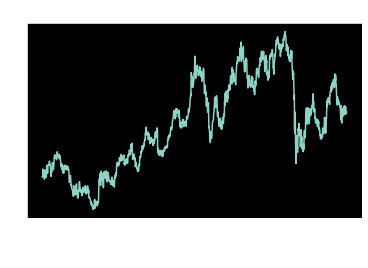

In [15]:
data["Close"].plot(title= 'Série Temporal Cotações')

In [5]:
#DataFrame com os Retornos
x = calcula_retornos(data)
x

,Close
Date,
2015-01-05,0.003272
2015-01-06,0.007609
2015-01-07,0.037756
2015-01-08,0.010395
2015-01-09,-0.034979
...,...
2021-03-30,0.014535
2021-03-31,-0.014327
2021-04-01,-0.021318


<AxesSubplot:title={'center':'Série Temporal dos Retornos'}, xlabel='Date'>

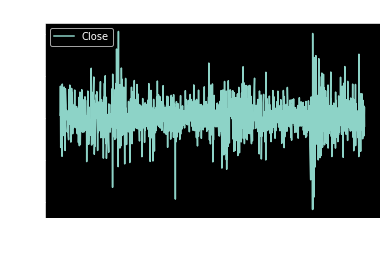

In [17]:
x.plot(title = "Série Temporal dos Retornos")

array([[<AxesSubplot:title={'center':'Close'}>]], dtype=object)

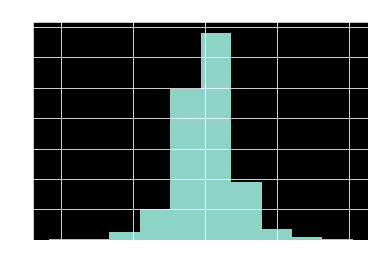

In [18]:
#Histograma dos Retornos
x.hist()

In [19]:
x.describe()

,Close
count,1549.000000
mean,0.000465
std,0.020482
min,-0.108654
25%,-0.011321
50%,0.000000
75%,0.011949
max,0.102696


### Simula Preço de Ativos (preencher caixa de texto)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Para quantos períodos de tempo? 100
Quantas simulações? 1000
DataFrame = 1, call = 2 ou put = 3? 1


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,10.255931,9.310854,10.308922,10.174448,9.915502,9.990454,10.483147,10.047097,10.009344,10.182826,...,10.032989,9.639113,9.925639,10.151757,10.178323,10.381803,9.982040,10.143835,9.380002,9.983015
1,10.613058,9.492285,10.227518,10.671415,9.729614,9.833121,10.291550,9.972973,9.858849,10.666368,...,9.824122,9.308494,10.679509,10.448002,10.162139,10.638747,10.004205,9.865229,9.808996,9.980387
2,10.631098,9.657411,9.721629,10.565113,9.874202,9.850572,9.990408,10.069976,9.489884,11.160364,...,9.710311,9.225443,11.403248,10.655768,10.447042,10.814145,9.804218,9.828361,9.743299,10.007968
3,11.173004,10.038058,9.885796,10.295024,10.367495,9.778835,9.982865,9.909059,9.441814,11.217314,...,9.475590,8.914467,11.054696,11.510324,10.818115,11.381070,9.351094,10.017661,10.284218,10.293427
4,11.205060,9.853596,10.065875,9.667470,10.299521,9.683800,9.880049,9.979231,9.261790,11.105318,...,9.544849,9.163111,10.701867,11.711742,11.176883,11.273506,9.362242,10.584019,10.369597,10.481793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,8.132264,9.433592,6.362974,12.162339,10.315798,6.674244,13.346974,10.923438,12.524164,12.858553,...,4.486758,16.641392,9.842000,14.112066,14.960714,13.480194,6.019122,8.509293,10.517660,9.431663
97,8.351557,9.392571,6.246491,12.381680,10.190443,6.534450,13.073527,10.899666,12.520325,12.390372,...,4.382799,16.876985,9.710234,14.649924,15.728897,14.483852,5.993517,8.442494,10.653011,9.582983
98,8.204975,9.680374,6.789300,12.609738,10.363315,6.438338,14.213416,10.558157,12.888699,12.850176,...,4.294465,15.917484,9.512015,15.634789,16.208237,14.395393,6.026439,8.587334,10.776615,9.737235
99,8.443991,9.457391,6.616162,12.191615,10.419679,6.404750,14.079124,10.729943,13.137134,13.508487,...,4.024471,15.500620,9.723419,15.136161,16.117576,14.494909,5.975602,8.310534,10.094670,9.456557


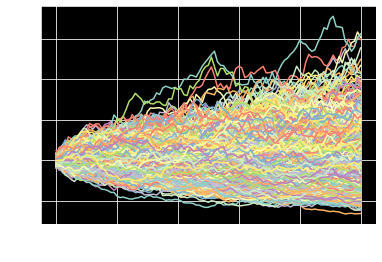

In [20]:
S = mc_normal(x)
display(S)
plt.plot(S)
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('Valor $')
plt.show()

### Precifica Call Europeia por MC (preencher caixa de texto)

In [32]:
mc_normal(x)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Para quantos períodos de tempo? 100
Quantas simulações? 100000
DataFrame = 1, call = 2 ou put = 3? 2


0.25293466116907753

### Precifica Put Europeia por MC (preencher caixa de texto)

In [23]:
mc_normal(x)

Qual o preço da ação? 10
Qual o preço de exercício? 10
Para quantos períodos de tempo? 100
Quantas simulações? 100000
DataFrame = 1, call = 2 ou put = 3? 3


0.7609599095914445

### Precifica Call Europeia por BS (preencher caixa de texto)

In [33]:
o = euro_vanilla_call(x)
o

Qual o preço da ação? 10
Qual o preço de exercício? 12
Quantos períodos até a data de expiração? 100


0.27

### Precifica Put Europeia por BS (preencher caixa de texto)

In [11]:
o = euro_vanilla_put(x)
o

Qual o preço da ação? 10
Qual o preço de exercício? 10
Quantos períodos até a data de expiração? 100


0.77

### Precifica Call Exótica por MC - Preço final igual a média dos últimos 5 dias (preencher caixa de texto)

In [26]:
exotica(x, retornar = 2)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Para quantos períodos de tempo? 100
Quantas simulações? 100000


0.23721694528058687

### Precifica Put Exótica por MC - Preço final igual a média dos últimos 5 dias (preencher caixa de texto)

In [27]:
exotica(x, retornar = 3)

Qual o preço da ação? 10
Qual o preço de exercício? 10
Para quantos períodos de tempo? 100
Quantas simulações? 1000000


0.7515756405517806

### Precifica Higher Binária por MC (preencher caixa de texto)


In [28]:
binaria(x, retornar = 1)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Qual o valor da recompensa? 1000
Para quantos períodos de tempo? 100
Quantas simulações? 100000


170.7684573093479

### Precifica Lower Binária por MC (preencher caixa de texto)

In [30]:
binaria(x, retornar = 2)

Qual o preço da ação? 10
Qual o preço de exercício? 12
Qual o valor da recompensa? 1000
Para quantos períodos de tempo? 100
Quantas simulações? 100000


817.1451297977935